In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA: True
cuda:0


In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)


In [3]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


In [4]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final


In [5]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2 * hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2 * hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2 * hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))

In [6]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas


In [7]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model


In [8]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                


In [9]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))


In [10]:
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)


In [11]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm


In [12]:
def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]


In [13]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break


In [14]:
def train_copy_task():
    """Train the simple copy task."""
    num_words = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))
 
    dev_perplexities = []
    
    if USE_CUDA:
        model.cuda()

    for epoch in range(10):
        
        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad(): 
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)
        
    return dev_perplexities


/home/ghost/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0
Epoch Step: 50 Loss: 19.720032 Tokens per Sec: 13314.147152
Epoch Step: 100 Loss: 17.850552 Tokens per Sec: 18832.917925
Evaluation perplexity: 7.165516

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  5 8 7 5 8 7 5 8 7

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 8 8 8 8 8 8 8

Epoch 1
Epoch Step: 50 Loss: 15.429652 Tokens per Sec: 19106.808294
Epoch Step: 100 Loss: 11.758204 Tokens per Sec: 18936.812138
Evaluation perplexity: 3.761093

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 5 3 8 7 5

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 8 2 5 8 3 2

Epoch 2
Epoch Step: 50 Loss: 9.917424 Tokens per Sec: 18803.309120
Epoch Step: 100 Loss: 8.949947 Tokens per Sec: 21505.766551
Evaluation perplexity: 2.573576

Example #1
Src :  4 8 5 7 10 3 7 8 5
Trg :  4 8 5 7 10 3 7 8 5
Pred:  4 8 5 7 3 5 7 8 10

Example #2
Src :  8 8 3 6 5 2 8 6 2
Trg :  8 8 3 6 5 2 8 6 2
Pred:  8 8 3 

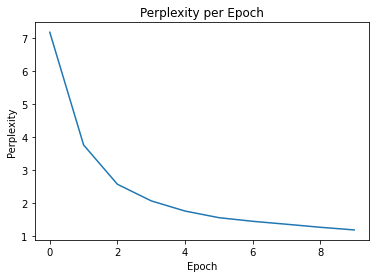

In [15]:
dev_perplexities = train_copy_task()

def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

In [16]:
import spacy
spacy_en = spacy.load('en_core_web_sm')
def tokenize_en(text):
        print(text)
        return [tok.text for tok in spacy_en.tokenizer(text)]
out = tokenize_en('Hello world!')



Hello world!


In [39]:
out

['Hello', 'world', '!']

In [48]:
from __future__ import print_function
import os

from kaznlp.normalization.ininorm import Normalizer

from kaznlp.tokenization.tokrex import TokenizeRex
from kaznlp.tokenization.tokhmm import TokenizerHMM

from kaznlp.lid.lidnb import LidNB

from kaznlp.morphology.analyzers import AnalyzerDD
from kaznlp.morphology.taggers import TaggerHMM

In [49]:
from kaznlp.tokenization.tokhmm import TokenizerHMM
mdl = os.path.join('kaznlp', 'tokenization', 'tokhmm.mdl')
ininormer = TokenizerHMM(model = mdl)
txt = u'Көш жүре түзеледі.Ақсақ қой түстен кейін маңырайды.'
array_tok = ininormer.tokenize(txt)

In [51]:
array_tok

[['Көш', 'жүре', 'түзеледі', '.'],
 ['Ақсақ', 'қой', 'түстен', 'кейін', 'маңырайды', '.']]

A REAL WORLD EXAMPLE 

In [ ]:
!pip3 install git+git://github.com/pytorch/text spacy 
!python3 -m spacy download en
!python3 -m spacy download de

  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-e2ltnw1f
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-e2ltnw1f
  Running command git submodule update --init --recursive -q
You should consider upgrading via the '/home/ghost/anaconda3/bin/python -m pip install --upgrade pip' command.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.6 MB 66 kB/s 
You should consider upgrading via the '/home/ghost/anaconda3/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     |████████████████████████████████| 18.8 MB 137 kB/s 
You should consider upgrading via the '/home/ghost/anaconda3/bin/python3 -m pip install --u

In [15]:
!export LC_ALL="en_US.UTF-8"

In [20]:
from torchtext import data, datasets
from torchtext.legacy import data
from torchtext.legacy import datasets

if True:
    import spacy
    spacy_de = spacy.load("de_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    print("KEk")

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    print("KEK")
    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    print("KEK")
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN) 
    print("KEK")
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    print("KEK")
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]



ModuleNotFoundError: No module named 'torchtext'

In [ ]:
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]


Error: Session cannot generate requests

In [35]:
import pandas as pd

df = pd.read_csv('out_final.csv')

In [36]:
df.head()

,samples,predicted
0,Әлеуметтік желілерде ЕЦ-166/5 төтенше қауіпсіз...,Әлеуметтік желілерде ЕЦ жүз алпыс алты бөлу бе...
1,"Бұл – фейк, оны Нұр-Сұлтан қаласы бойынша ҚАЖД...","Бұл фейк, оны Нұр Сұлтан қаласы бойынша ҚАЖД..."
2,Кейбір желі қолданушылары мекеменің алдына қой...,Кейбір желі қолданушылары мекеменің алдына қой...
3,Шын мәнінде дәрігерлер колонияға созылмалы аур...,Шын мәнінде дәрігерлер колонияға созылмалы аур...
4,«17 наурызда таңғы сағат 06:30 шамасында Нұр-С...,«он жетінші наурызда таңғы сағат алты отыз шам...


In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_size = 0.8

X = df.drop(columns = ["predicted"]).copy()
y = df["predicted"]

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)



TypeError: an integer is required (got type bytes)

In [18]:
test_size=0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)


NameError: name 'train_test_split' is not defined

In [ ]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(3001781, 1)
(3001781,)
(375223, 1)
(375223,)
(375223, 1)
(375223,)


(None, None)

In [ ]:
y_train

NameError: name 'y_train' is not defined

In [ ]:
X_train

,samples
681727,"Сонымен қатар, Қылмыстық кодекстің 297-бабы бо..."
1025183,"Баспасөз қызметінің мәліметінше, су тасқынынан..."
2698063,Б кезеңінде жаһандық жүйе пайда болды (1750 — ...
1188840,Ол қазіргі Атырау облысының Манаш ауылында дүн...
2725731,"Қосымша жіптен 156 шалу теріп алып, бірнеше қа..."
...,...
2826766,"Осының бәрі жергілікті халықтың кедейленіп, са..."
3024945,Боланден () — Германия Федеративтік Республика...
3711233,И.\n
73991,Қарағанды облысының Шахтинск қаласында тұратын...


In [ ]:
df

,samples,predicted
0,Әлеуметтік желілерде ЕЦ-166/5 төтенше қауіпсіз...,Әлеуметтік желілерде ЕЦ жүз алпыс алты бөлу бе...
1,"Бұл – фейк, оны Нұр-Сұлтан қаласы бойынша ҚАЖД...","Бұл фейк, оны Нұр Сұлтан қаласы бойынша ҚАЖД..."
2,Кейбір желі қолданушылары мекеменің алдына қой...,Кейбір желі қолданушылары мекеменің алдына қой...
3,Шын мәнінде дәрігерлер колонияға созылмалы аур...,Шын мәнінде дәрігерлер колонияға созылмалы аур...
4,«17 наурызда таңғы сағат 06:30 шамасында Нұр-С...,«он жетінші наурызда таңғы сағат алты отыз шам...
...,...,...
3752222,Қазақтар шекара шебіндегі бекіністерге жүйелі ...,Қазақтар шекара шебіндегі бекіністерге жүйелі ...
3752223,Көтеріліске тағы да Жоламан батыр басшылық етт...,Көтеріліске тағы да Жоламан батыр басшылық етт...
3752224,Жоламан батыр бастаған қозғалыстың отаршылдыққ...,Жоламан батыр бастаған қозғалыстың отаршылдыққ...
3752225,Көтерілістің әр жерде шашыраңқы жүруі мен оған...,Көтерілістің әр жерде шашыраңқы жүруі мен оған...


In [ ]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]




In [30]:
'''def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['samples']))
    #print("trg:", " ".join(vars(src_field[0])[1]), "\n")

    #print("Most common words (src):")
    #print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    #print("Most common words (trg):")
    #print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    #print("First 10 words (src):")
    #print("\n".join(
    #    '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    #print("First 10 words (trg):")
    #print("\n".join(
    #    '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(X_train, X_valid, X_test, y_train, y_valid)'''


'def print_data_info(train_data, valid_data, test_data, src_field, trg_field):\n    """ This prints some useful stuff about our data sets. """\n\n    print("Data set sizes (number of sentence pairs):")\n    print(\'train\', len(train_data))\n    print(\'valid\', len(valid_data))\n    print(\'test\', len(test_data), "\n")\n\n    print("First training example:")\n    print("src:", " ".join(vars(train_data[0])[\'samples\']))\n    #print("trg:", " ".join(vars(src_field[0])[1]), "\n")\n\n    #print("Most common words (src):")\n    #print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")\n    #print("Most common words (trg):")\n    #print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")\n\n    #print("First 10 words (src):")\n    #print("\n".join(\n    #    \'%02d %s\' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")\n    #print("First 10 words (trg):")\n    #print("\n".join(\n    #    \'%02d %s\' % (i, t) fo

In [31]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(X_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [19]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    print("KEK")

    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    print("KEK")
    for epoch in num_epochs:
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            


In [34]:
df

,samples,predicted
0,Әлеуметтік желілерде ЕЦ-166/5 төтенше қауіпсіз...,Әлеуметтік желілерде ЕЦ жүз алпыс алты бөлу бе...
1,"Бұл – фейк, оны Нұр-Сұлтан қаласы бойынша ҚАЖД...","Бұл фейк, оны Нұр Сұлтан қаласы бойынша ҚАЖД..."
2,Кейбір желі қолданушылары мекеменің алдына қой...,Кейбір желі қолданушылары мекеменің алдына қой...
3,Шын мәнінде дәрігерлер колонияға созылмалы аур...,Шын мәнінде дәрігерлер колонияға созылмалы аур...
4,«17 наурызда таңғы сағат 06:30 шамасында Нұр-С...,«он жетінші наурызда таңғы сағат алты отыз шам...
...,...,...
3752222,Қазақтар шекара шебіндегі бекіністерге жүйелі ...,Қазақтар шекара шебіндегі бекіністерге жүйелі ...
3752223,Көтеріліске тағы да Жоламан батыр басшылық етт...,Көтеріліске тағы да Жоламан батыр басшылық етт...
3752224,Жоламан батыр бастаған қозғалыстың отаршылдыққ...,Жоламан батыр бастаған қозғалыстың отаршылдыққ...
3752225,Көтерілістің әр жерде шашыраңқы жүруі мен оған...,Көтерілістің әр жерде шашыраңқы жүруі мен оған...


In [20]:
model = make_model(len(df['samples']), len(df['predicted']),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)



/home/ghost/anaconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
dev_perplexities = train(model, print_every=100)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


Error: Session cannot generate requests

In [32]:
df

,samples,predicted
0,Әлеуметтік желілерде ЕЦ-166/5 төтенше қауіпсіз...,Әлеуметтік желілерде ЕЦ жүз алпыс алты бөлу бе...
1,"Бұл – фейк, оны Нұр-Сұлтан қаласы бойынша ҚАЖД...","Бұл фейк, оны Нұр Сұлтан қаласы бойынша ҚАЖД..."
2,Кейбір желі қолданушылары мекеменің алдына қой...,Кейбір желі қолданушылары мекеменің алдына қой...
3,Шын мәнінде дәрігерлер колонияға созылмалы аур...,Шын мәнінде дәрігерлер колонияға созылмалы аур...
4,«17 наурызда таңғы сағат 06:30 шамасында Нұр-С...,«он жетінші наурызда таңғы сағат алты отыз шам...
...,...,...
3752222,Қазақтар шекара шебіндегі бекіністерге жүйелі ...,Қазақтар шекара шебіндегі бекіністерге жүйелі ...
3752223,Көтеріліске тағы да Жоламан батыр басшылық етт...,Көтеріліске тағы да Жоламан батыр басшылық етт...
3752224,Жоламан батыр бастаған қозғалыстың отаршылдыққ...,Жоламан батыр бастаған қозғалыстың отаршылдыққ...
3752225,Көтерілістің әр жерде шашыраңқы жүруі мен оған...,Көтерілістің әр жерде шашыраңқы жүруі мен оған...


In [ ]:
from torchtext.legacy.data import Field
from kaznlp.tokenization.tokhmm import TokenizerHMM
from torchtext.legacy.datasets import IWSLT

if True:
    mdl = os.path.join('kaznlp', 'tokenization', 'tokhmm.mdl')
    ininormer = TokenizerHMM(model = mdl)

    def tokenize_kz_unnormalized(text):
        return [tok.text for tok in ininormer.tokenize(text)]

    def tokenize_kz_normalized(text):
        return [tok.text for tok in ininormer.tokenize(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = Field(tokenize=tokenize_kz_unnormalized, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = Field(tokenize=tokenize_kz_normalized, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = IWSLT.splits(
        exts=('.samples', '.predicted'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [ ]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')

def tokenize(label, line):
    return line.split()

tokens = []
for label, line in train_iter:
    print("LABEL", label)
    print("LINE", line)
    tokens += tokenize(label, line)

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as pl

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

26422272it [00:08, 3050427.68it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



29696it [00:00, 312815.48it/s]           


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



4422656it [00:01, 2481844.20it/s]                             


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



6144it [00:00, 4563450.29it/s]          


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/home/ghost/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [17]:
print(training_data)

NameError: name 'training_data' is not defined

In [26]:
len(training_data[0])

2

In [ ]:
training_data[0]

In [43]:
df

,samples,predicted
0,Әлеуметтік желілерде ЕЦ-166/5 төтенше қауіпсіз...,Әлеуметтік желілерде ЕЦ жүз алпыс алты бөлу бе...
1,"Бұл – фейк, оны Нұр-Сұлтан қаласы бойынша ҚАЖД...","Бұл фейк, оны Нұр Сұлтан қаласы бойынша ҚАЖД..."
2,Кейбір желі қолданушылары мекеменің алдына қой...,Кейбір желі қолданушылары мекеменің алдына қой...
3,Шын мәнінде дәрігерлер колонияға созылмалы аур...,Шын мәнінде дәрігерлер колонияға созылмалы аур...
4,«17 наурызда таңғы сағат 06:30 шамасында Нұр-С...,«он жетінші наурызда таңғы сағат алты отыз шам...
...,...,...
3752222,Қазақтар шекара шебіндегі бекіністерге жүйелі ...,Қазақтар шекара шебіндегі бекіністерге жүйелі ...
3752223,Көтеріліске тағы да Жоламан батыр басшылық етт...,Көтеріліске тағы да Жоламан батыр басшылық етт...
3752224,Жоламан батыр бастаған қозғалыстың отаршылдыққ...,Жоламан батыр бастаған қозғалыстың отаршылдыққ...
3752225,Көтерілістің әр жерде шашыраңқы жүруі мен оған...,Көтерілістің әр жерде шашыраңқы жүруі мен оған...


In [3]:
!ls splitted_csv/

out_test_X.csv	out_test.zip	 out_train_Y.zip  out_valid_Y.csv
out_test_X.zip	out_train_X.csv  out_train.zip	  out_valid_Y.zip
out_test_Y.csv	out_train_X.zip  out_valid_X.csv  out_valid.zip
out_test_Y.zip	out_train_Y.csv  out_valid_X.zip


In [32]:
import pandas as pd


X_train = pd.read_csv('X_train.txt', error_bad_lines=False, sep='\n', names=['SRC'])
y_train = pd.read_csv('Y_train.txt', error_bad_lines=False, sep='\n', names=['TRG'])

In [ ]:
X_train

In [ ]:
y_train

In [35]:
training_data = X_train['SRC']

In [36]:
training_data = training_data.values.tolist()

In [37]:
training_data = {i : training_data[i] for i in range(0, len(training_data))}

In [ ]:
training_data

In [39]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    print(f)
    for string_ in f:
      print(string_)
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

In [40]:
def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                            dtype=torch.long)
    data.append((de_tensor_, en_tensor_))
  return data

In [45]:
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator

en_tokenizer = get_tokenizer('spacy', language='en')


def build_vocab(filepath, tokenizer):
  counter = Counter()
  f =  "I'm big molodec!"
  for string_ in f:
    counter.update(tokenizer(string_))
  return build_vocab_from_iterator(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


en_vocab = build_vocab('kek', en_tokenizer)


/home/ghost/anaconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [46]:
en_vocab

Vocab()

In [61]:
en_tokenizer('Toronto konofest tarantino "Koymalik" filmin, al Rodriges bolsa ozinin (El marachi) kinocin korcetkemen.')

['Toronto',
 'konofest',
 'tarantino',
 '"',
 'Koymalik',
 '"',
 'filmin',
 ',',
 'al',
 'Rodriges',
 'bolsa',
 'ozinin',
 '(',
 'El',
 'marachi',
 ')',
 'kinocin',
 'korcetkemen',
 '.']

In [60]:
def flatten(t):
    return [item for sublist in t for item in sublist]

out = ininormer.tokenize('Торонто кинофестивалінде Тарантино «Қоймалық иттер» фильмін, ал Родригес болса өзінің «Эль Мариачи» (El Mariachi) киносын көрсеткен.')
out = flatten(out)
out

['Торонто',
 'кинофестивалінде',
 'Тарантино',
 '«',
 'Қоймалық',
 'иттер',
 '»',
 'фильмін',
 ',',
 'ал',
 'Родригес',
 'болса',
 'өзінің',
 '«',
 'Эль',
 'Мариачи',
 '»',
 '(',
 'El',
 'Mariachi',
 ')',
 'киносын',
 'көрсеткен',
 '.']

In [70]:


def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return build_vocab_from_iterator(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

ininormer = TokenizerHMM(model = mdl)

def tokenize_kz_unnormalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    out = flatten(out)
    return out

def tokenize_kz_normalized(text):
    out = [tok for tok in ininormer.tokenize(text)]
    out = flatten(out)
    return out


unnormalize_text = build_vocab('splitted_csv/out_test_X.txt', tokenize_kz_unnormalized)
#normalize_text = build_vocab('splitted_csv/out_train_Y.csv', tokenize_kz_normalized)


TypeError: __init__() got an unexpected keyword argument 'specials'

In [ ]:
normalize_text = build_vocab('splitted_csv/out_train_Y.csv', tokenize_kz_normalized)

In [34]:
df

NameError: name 'df' is not defined